In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.linear_model import ElasticNetCV
import numpy as np
from sklearn.metrics import r2_score

In [ ]:
df = pd.read_json("data/raw/stockfish_150.ndjson", lines = True)
df = df.fillna(0)

print(len(df))
df = df[df['white_cpl'].apply(lambda x: len(x) > 0)]
df = df[df['black_cpl'].apply(lambda x: len(x) > 0)]
print(len(df))

In [13]:
import os
import json

# Specify the folder containing NDJSON files
folder_path = 'data/raw/fics'

# List to store all data from all files
all_data = []

# Iterate over all files in the folder
for file_name in os.listdir(folder_path):
    if file_name.endswith('.ndjson'):
        file_path = os.path.join(folder_path, file_name)
        
        # Open and read the NDJSON file
        with open(file_path, 'r') as file:
            for line in file:
                data = json.loads(line.strip())  # Parse each line as JSON
                all_data.append(data)

# `all_data` now contains all the data from all NDJSON files
df = pd.DataFrame(all_data)
df = df.fillna(0)

In [14]:
df.head(2)

,event,round,white,black,result,moves,white_elo,black_elo,ECO,Opening,...,end_r,end_K,end_n,end_Q,end_b,end_B,end_q,end_N,promotion,can_claim_draw
0,FICS rated blitz game,?,nossamel,aimtomate,1-0,"[e2e4, e7e5, g1f3, d7d6, b1c3, c8g4, h2h3, g4h...",1679,1778,C41,Philidor's defence,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,FICS rated blitz game,?,jorgemonroy,ynots,1-0,"[e2e4, e7e5, f1c4, g8f6, b1c3, f8b4, d2d3, e8g...",1474,1332,C26,Vienna game,...,2.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [22]:
df["white_elo"]

0        1679
1        1474
2        1535
3        1274
4        1225
         ... 
25995     875
25996    1166
25997    1286
25998    1291
25999    1563
Name: white_elo, Length: 25724, dtype: object

In [40]:
print(len(df))
df = df.dropna(subset=['white_elo', 'black_elo'])
print(len(df))
df = df[df['white_cpl'].apply(lambda x: isinstance(x, (list, str)) and len(x) > 0)]
df = df[df['black_cpl'].apply(lambda x: isinstance(x, (list, str)) and len(x) > 0)]
print(len(df))
df['white_elo'] = pd.to_numeric(df['white_elo'], errors='coerce')
df['black_elo'] = pd.to_numeric(df['black_elo'], errors='coerce')


df["ECO"] = df["ECO"].astype('category')
df["Opening"] = df["Opening"].astype('category')
df["result"] = df["result"].astype('category')

df["mean_elos"] = np.square(df[['white_elo', 'black_elo']].mean(axis=1))
df["diff_elos"] = df['white_elo'] - df['black_elo']

df['white_mean'] = df['white_cpl'].apply(np.mean)
df['white_std'] = df['white_cpl'].apply(np.std)
df['white_min'] = df['white_cpl'].apply(np.min)
df['white_max'] = df['white_cpl'].apply(np.max)

df['black_mean'] = df['black_cpl'].apply(np.mean)
df['black_std'] = df['black_cpl'].apply(np.std)
df['black_min'] = df['black_cpl'].apply(np.min)
df['black_max'] = df['black_cpl'].apply(np.max)

df['stockfish_mean'] = df['stockfish_eval'].apply(np.mean)
df['stockfish_std'] = df['stockfish_eval'].apply(np.std)
df['stockfish_min'] = df['stockfish_eval'].apply(np.min)
df['stockfish_max'] = df['stockfish_eval'].apply(np.max)



25724
25724
25724


In [41]:
cols = df.columns.tolist()

to_remove = ["moves", "white_elo", "black_elo", "Opening", "white_cpl", "black_cpl", "diff_elos", "stockfish_eval", "white", "black", "event"]

dep_var = "mean_elos"

df_dropped = df.drop(columns=to_remove)

In [42]:
from fastai.vision.all import *
from fastai.text.all import *
from fastai.collab import *
from fastai.tabular.all import *
import pandas as pd

cont,cat = cont_cat_split(df_dropped, 1, dep_var=dep_var)

In [43]:
cont = ['queen_moved_at', 'total_checks', 'first_check_at', 'queen_changed_at', 'total_moves', 'end_r',
 'end_p', 'end_b', 'end_n', 'end_q', 'end_N', 'end_P', 'end_Q', 'end_B', 'end_R', 'promotion', 'can_claim_draw',
 'white_mean', 'white_std', 'white_min', 'white_max', 'black_mean', 'black_std', 'black_min', 'black_max', 'stockfish_mean',
 'stockfish_std', 'stockfish_min', 'stockfish_max']

In [44]:
features = ["white_mean", "white_std", "white_min", "white_max", "black_mean", "black_std", "black_min", "black_max", "stockfish_mean", "stockfish_std", "stockfish_min", "stockfish_max"]

In [45]:
X = df[cont]
X = X.fillna(0)
y1 = df["mean_elos"]
y2 = df["diff_elos"]

X_train, X_test = X[:800], X[800:]
y1_train, y1_test = df["mean_elos"][:800], df["mean_elos"][800:]
y2_train, y2_test = df["diff_elos"][:800], df["diff_elos"][800:]

In [46]:
rf_mean = RandomForestRegressor(n_estimators=50, n_jobs=-1)
rf_mean.fit(X_train, y1_train)

c:\Users\jonat\anaconda3\envs\py310\lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\jonat\anaconda3\envs\py310\lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\jonat\anaconda3\envs\py310\lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\Users\jonat\anaconda3\envs\py310\lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isi

RandomForestRegressor(n_estimators=50, n_jobs=-1)

In [47]:
mean_pred_rf = rf_mean.predict(X_test)
print(mean_absolute_error(y1_test, mean_pred_rf))
print(r2_score(y1_test, mean_pred_rf))

544711.7657601107
0.10441282358238102


c:\Users\jonat\anaconda3\envs\py310\lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\jonat\anaconda3\envs\py310\lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\jonat\anaconda3\envs\py310\lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\Users\jonat\anaconda3\envs\py310\lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isi

In [48]:
rf_diff = RandomForestRegressor(n_estimators=50, n_jobs=-1)
rf_diff.fit(X_train, y2_train)

c:\Users\jonat\anaconda3\envs\py310\lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\jonat\anaconda3\envs\py310\lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\jonat\anaconda3\envs\py310\lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\Users\jonat\anaconda3\envs\py310\lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isi

RandomForestRegressor(n_estimators=50, n_jobs=-1)

In [49]:
dff_pred_rf = rf_diff.predict(X_test)
print(mean_absolute_error(y2_test, dff_pred_rf))
print(r2_score(y2_test, dff_pred_rf))

133.67344567485154
0.05064996819940437


c:\Users\jonat\anaconda3\envs\py310\lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\jonat\anaconda3\envs\py310\lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\jonat\anaconda3\envs\py310\lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\Users\jonat\anaconda3\envs\py310\lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isi

In [50]:
len(X_test)
len(dff_pred_rf)

24924

In [51]:
white_pred = []
black_pred = []

for i in range(len(dff_pred_rf)):
    white_pred.append(mean_pred_rf[i] + dff_pred_rf[i]/2)
    black_pred.append(mean_pred_rf[i] - dff_pred_rf[i]/2)


all_preds = white_pred + black_pred

In [52]:
white_actual = []
black_actual = []
for ind, row in df[800:].iterrows():
    white_actual.append(row["white_elo"])
    black_actual.append(row["black_elo"])

all_actual = white_actual + black_actual

In [53]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(all_actual, all_preds)

2136937.324513521

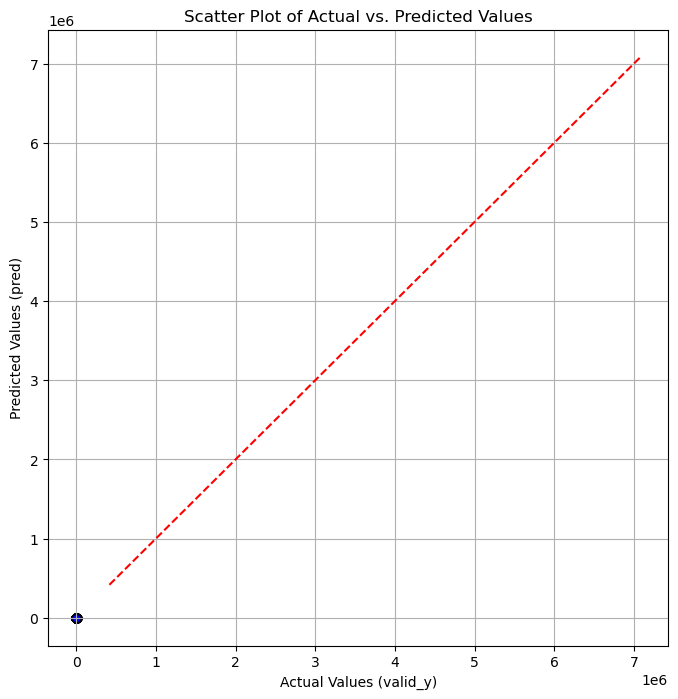

In [56]:
import matplotlib.pyplot as plt

# Assuming valid_y and pred are your actual and predicted values
# valid_y = [your actual values]
# pred = [your predicted values]

plt.figure(figsize=(8, 8))
plt.scatter((all_actual), np.sqrt(all_preds), edgecolor='k', color='b', alpha=0.5)

# Adding a diagonal line to indicate perfect predictions
plt.plot([min(y1), max(y1)], [min(y1), max(y1)], 'r--')

# Adding titles and labels
plt.title('Scatter Plot of Actual vs. Predicted Values')
plt.xlabel('Actual Values (valid_y)')
plt.ylabel('Predicted Values (pred)')

# Adding a grid for better readability
plt.grid(True)

# Show the plot
plt.show()